In [100]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [101]:
import numpy as np
import pandas as pd

In [102]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [103]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [104]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [105]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [106]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [107]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [108]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [109]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [110]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [111]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [117]:
# Latest Date
lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
lastDate = str(lastDate)
lastDate = lastDate[2:]
lastDate = lastDate[:-3]
lastDate

'2017-08-23'

# Exploratory Climate Analysis

Text(0.5, 0, 'Date')

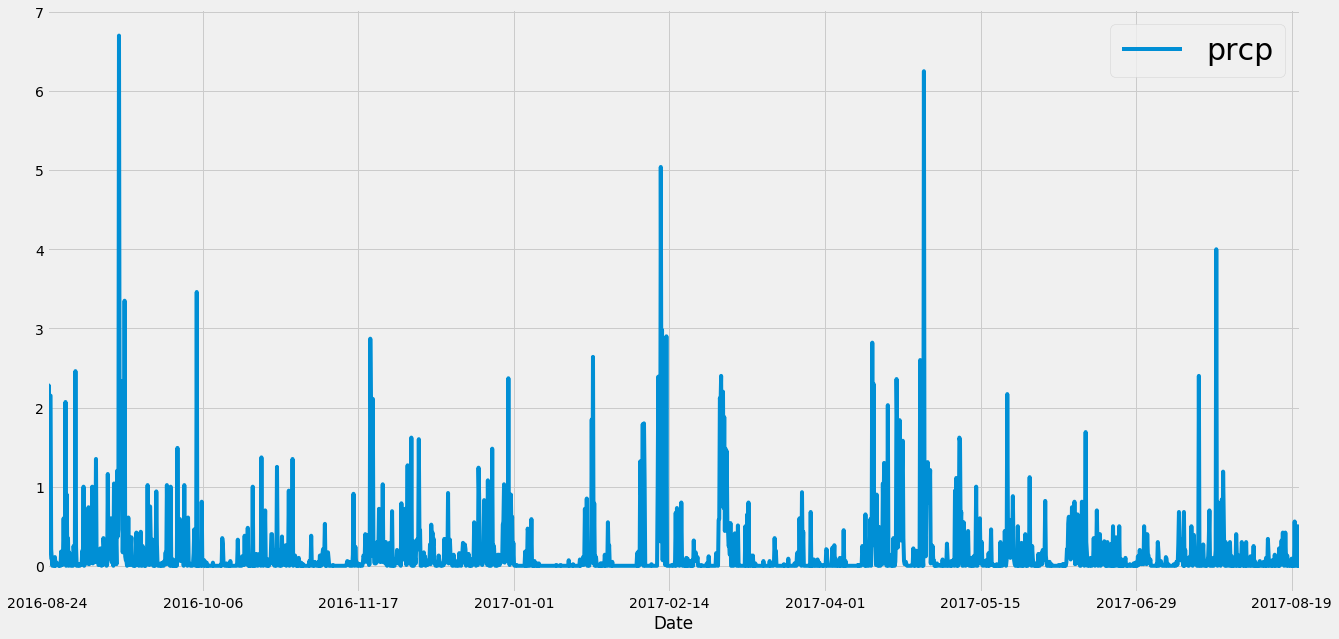

In [119]:
# Calculate the date 1 year ago from the last data point in the database
lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')
oneYearAgo = lastDate - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12Results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= oneYearAgo).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitationPd = pd.DataFrame(last12Results)
precipitationPd = precipitationPd.dropna().set_index("date")

# Sort the dataframe by date
precipitationPd = precipitationPd.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitationPd.plot(figsize=(20,10))
plt.legend(loc="upper right", fontsize=30)
plt.xlabel("Date")

In [72]:
# Use Pandas to calcualte the summary statistics for the precipitation dataprecipitationPd.
precipitationPd.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [74]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [76]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activeStations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
activeStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [81]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

mostActiveStationId = activeStations[0][0]

temperatures = session.query(func.min(Measurement.tobs).label('Lowest'), func.max(Measurement.tobs).label('Highest'),
    func.avg(Measurement.tobs).label('Avg')).filter(Measurement.station == mostActiveStationId).all()
temperatures

[(54.0, 85.0, 71.66378066378067)]

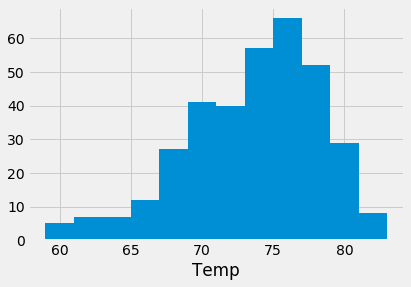

In [131]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last12MonthsResults = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= oneYearAgo).filter(Measurement.station == mostActiveStationId).all()

last12MonthsResults = pd.DataFrame(last12MonthsResults)
plt.close()
plt.xlabel("Temp")
plt.hist(last12MonthsResults.tobs, bins=12)
plt.show()

In [167]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [133]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tempResult = calc_temps("2016-08-23", "2017-08-30")
print(tempResult)

[(58.0, 74.59058295964125, 87.0)]


In [169]:
# FLASK
def calc_temps_with_session(start_date, end_date, session):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

In [ ]:
from flask import Flask, jsonify

app = Flask(__name__)

@app.route("/")
def home():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

@app.route("/api/v1.0/precipitation")
def precipitation():
    session = Session(engine)
    results = session.query(Measurement.date, Measurement.prcp)
    session.close()
    
    precipitation = []
    for date, prcp in results:
        prec_dict = {}
        prec_dict[date] = prcp
        precipitation.append(prec_dict)

    return jsonify(precipitation)


@app.route("/api/v1.0/stations")
def stations():
    session = Session(engine)
    results = session.query(Station.station)
    session.close()
    
    stations = []
    for station in results:
        stations.append(station)
    
    return jsonify(stations)


@app.route("/api/v1.0/tobs")
def tobs():
    session = Session(engine)
    
    # Latest Date
    lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    
    lastDate = str(lastDate)
    lastDate = lastDate[2:]
    lastDate = lastDate[:-3]
    lastDate = dt.datetime.strptime(lastDate, '%Y-%m-%d')
    oneYearAgo = lastDate - dt.timedelta(days=365)
    
    lastYearResults = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= oneYearAgo).all()
    session.close()
    
    temps = []
    for date, tobs in lastYearResults:
        temps.append(tobs)
        
    return jsonify(temps)


@app.route("/api/v1.0/<start>")
def infoForDate(start):
    # Latest Date
    session = Session(engine)
    lastDate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    
    lastDate = str(lastDate)
    lastDate = lastDate[2:]
    lastDate = lastDate[:-3]
    lastDate
    
    tempData = calc_temps_with_session(start, lastDate, session)
    session.close()
    
    return jsonify(tempData)


@app.route("/api/v1.0/<start>/<end>")
def infoForPeriod(start,end):
    # Latest Date
    session = Session(engine)
    tempData = calc_temps_with_session(start, end, session)
    session.close()
    
    return jsonify(tempData)



if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [10/Aug/2019 13:28:52] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [10/Aug/2019 13:29:39] "GET /api/v1.0/2016-08-23 HTTP/1.1" 200 -
127.0.0.1 - - [10/Aug/2019 13:29:49] "GET /api/v1.0/2016-08-23/2017-08-23 HTTP/1.1" 200 -
